In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from torch.autograd import Variable

import torchvision
import torchvision.utils as vutils
from torchvision.utils import make_grid
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [3]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 4

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 3

# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
# CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


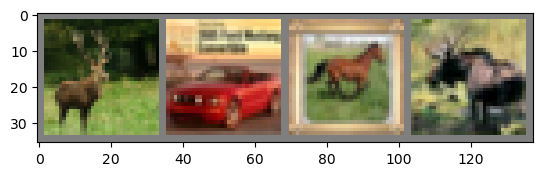

deer  car   horse deer 


In [5]:
# sampling CIFAR10 images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# sample images from training dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images and labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
# Model definition for CIFAR10
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x) # 28 * 28
        x = F.relu(x)
        x = self.conv2(x) # 24 * 24
        x = F.relu(x)
        x = self.pool(x) # 12 * 12
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [7]:
# loss function and optimization function for CIFAR10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
# CIFAR10 Training
for epoch in range(5):  # 2 loops over dataset

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # initialize gradiants to zero
        optimizer.zero_grad()

        # forward, backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # batch size=4, so 12500 batch calls for training data
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.988
[1,  4000] loss: 1.642
[1,  6000] loss: 1.510
[1,  8000] loss: 1.447
[1, 10000] loss: 1.369
[1, 12000] loss: 1.336
[2,  2000] loss: 1.234
[2,  4000] loss: 1.210
[2,  6000] loss: 1.186
[2,  8000] loss: 1.187
[2, 10000] loss: 1.190
[2, 12000] loss: 1.140
[3,  2000] loss: 1.004
[3,  4000] loss: 0.998
[3,  6000] loss: 1.045
[3,  8000] loss: 1.033
[3, 10000] loss: 1.031
[3, 12000] loss: 1.013
[4,  2000] loss: 0.888
[4,  4000] loss: 0.865
[4,  6000] loss: 0.890
[4,  8000] loss: 0.921
[4, 10000] loss: 0.934
[4, 12000] loss: 0.903
[5,  2000] loss: 0.736
[5,  4000] loss: 0.791
[5,  6000] loss: 0.807
[5,  8000] loss: 0.836
[5, 10000] loss: 0.843
[5, 12000] loss: 0.820
Finished Training


In [9]:
# saving weights for CIFAR10
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [10]:
# accuracy testing
correct = 0
total = 0

with torch.no_grad(): # testing, no gradient update
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # only run forward
        outputs = net(images)
        # the highest energy class = prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [11]:
# counting correct predictions per class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# testing, no gradient update
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # update correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 58.0 %
Accuracy for class: car   is 74.7 %
Accuracy for class: bird  is 52.1 %
Accuracy for class: cat   is 45.4 %
Accuracy for class: deer  is 48.7 %
Accuracy for class: dog   is 52.9 %
Accuracy for class: frog  is 84.2 %
Accuracy for class: horse is 57.6 %
Accuracy for class: ship  is 77.1 %
Accuracy for class: truck is 69.2 %


In [12]:
# CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

dataset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [13]:
# generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 3072),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 3, 32, 32)

In [14]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(3082, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 3072)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [15]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [16]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data.item()

In [17]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.item()

In [18]:
num_epochs = 10
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(dataloader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(batch_size, discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()

Starting epoch 0...
g_loss: 1.0024032592773438, d_loss: 1.2691622972488403
Starting epoch 1...
g_loss: 1.0642627477645874, d_loss: 0.9841224551200867
Starting epoch 2...
g_loss: 1.1021181344985962, d_loss: 1.2862257957458496
Starting epoch 3...
g_loss: 0.8593136668205261, d_loss: 1.3077893257141113
Starting epoch 4...
g_loss: 0.5830345153808594, d_loss: 1.0629013776779175
Starting epoch 5...
g_loss: 1.0914169549942017, d_loss: 1.2792332172393799
Starting epoch 6...
g_loss: 0.8489313125610352, d_loss: 1.0603424310684204
Starting epoch 7...
g_loss: 0.8178393840789795, d_loss: 1.1864572763442993
Starting epoch 8...
g_loss: 0.9411003589630127, d_loss: 1.4023160934448242
Starting epoch 9...
g_loss: 0.7830014228820801, d_loss: 1.2410087585449219


In [19]:
# save models
PATH = './cifar_gen.pth'
torch.save(generator.state_dict(), PATH)

PATH = './cifar_dis.pth'
torch.save(discriminator.state_dict(), PATH)

In [60]:
# generate 1k images
z = Variable(torch.randn(100, 100)).cuda()
images_list = []
labels_list = np.repeat(np.arange(10), 100)
for i in range(10):
    labels = Variable(torch.LongTensor(np.zeros(100) + i)).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    for j in range(100):
        images_list.append(sample_images[j])

In [62]:
# load image classifier
past_model = Net()
past_model.load_state_dict(torch.load('cifar_net.pth'))

<All keys matched successfully>

In [64]:
class GeneratedDataset(torch.utils.data.Dataset):
    def __init__(self, images_list, labels_list, transform=None, target_transform=None):
        self.images = images_list
        self.labels = labels_list
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx][0], self.labels[idx]

In [66]:
dataset = GeneratedDataset(images_list, labels_list)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                          shuffle=True)

print(len(images_list))
print(len(labels_list))
print(images_list[0].shape)

1000
1000
torch.Size([1, 3, 32, 32])


In [68]:
# loss function and optimization function for CIFAR10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [70]:
# counting correct predictions per class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# testing, no gradient update
with torch.no_grad():
    for data in dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # update correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 80.0 %
Accuracy for class: car   is 34.0 %
Accuracy for class: bird  is 56.0 %
Accuracy for class: cat   is 52.0 %
Accuracy for class: deer  is 72.0 %
Accuracy for class: dog   is 43.0 %
Accuracy for class: frog  is 66.0 %
Accuracy for class: horse is 28.0 %
Accuracy for class: ship  is 45.0 %
Accuracy for class: truck is 47.0 %


In [72]:
# CIFAR10 Training
for epoch in range(5):  # 2 loops over dataset

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # initialize gradiants to zero
        optimizer.zero_grad()
        
        # forward, backward
        outputs = net(inputs)
        loss = criterion(outputs, labels.type(torch.long))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # batch size=4, so 12500 batch calls for training data
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [74]:
# counting correct predictions per class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# testing, no gradient update
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # update correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 44.3 %
Accuracy for class: car   is 15.2 %
Accuracy for class: bird  is 5.9 %
Accuracy for class: cat   is 23.1 %
Accuracy for class: deer  is 2.9 %
Accuracy for class: dog   is 18.8 %
Accuracy for class: frog  is 52.3 %
Accuracy for class: horse is 21.1 %
Accuracy for class: ship  is 4.3 %
Accuracy for class: truck is 6.9 %
